# Descrição dos Atributos



Store - the store number (código da loja)

Date - the week of sales (semanas de vendas)

Weekly_Sales - sales for the given store (vendas por loja)

IsHoliday - whether the week is a special holiday week True – Holiday week False – Non-holiday week (se a semana é um feriado especial semana True – Semana de feriado False – Semana sem feriado)



MarkDown(1–5) — dados anônimos relacionados a descontos promocionais. Os dados de redução de preços só estão disponíveis após novembro de 2011.


Temperature - Temperature on the day of sale (temperatura do dia da venda)

Fuel_Price - Cost of fuel in the region (Preço total na região)

CPI – Prevailing consumer price index (Índice de preços ao consumidor)

Unemployment - Prevailing unemployment rate (taxa de desemprego)

==========================================================================================================================


Com base na ideia de validar as promoções e sua efetividade, o negócio está interessado em saber? 


Qual é o impacto dos feriados (promoções também) nas vendas das lojas?


Existe algum setor que desempenhe melhor?


É possível estimar as vendas das lojas por semana em datas futuras de 2012–11–02 a 2013–07-26? Se sim, quais seriam esses valores?




# Imports


In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.ticker as ticker
import inflection
import warnings
# import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestRegressor
from IPython.core.display    import HTML
from matplotlib              import pyplot as plt
from IPython.display         import Image
from datetime                import date, time, datetime, timedelta

warnings.filterwarnings("ignore")

## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    
    display( HTML( '') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
sns.set()

## Load Data


In [3]:
# juntando os datasets
df_train = pd.read_csv( 'walmart/train.csv', low_memory=False )
df_test = pd.read_csv('walmart/test.csv', low_memory=False )
df_stores = pd.read_csv( 'walmart/stores.csv', low_memory=False )
df_features = pd.read_csv( 'walmart/features.csv', low_memory=False )
df_sample_predictions = pd.read_csv( 'walmart/sampleSubmission.csv', low_memory=False )

# merge train
df = df_train.merge(df_stores,how='inner', on='Store').merge(df_features, how='inner', on=['Store', 'Date', 'IsHoliday'])

# merge test
df_final_test = df_test.merge(df_stores,how='inner', on='Store').merge(df_features, how='inner', on=['Store', 'Date', 'IsHoliday'])

In [66]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11


In [60]:
df_final_test.head()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,Week_Of_Year
0,1,1,2012-11-02,False,3,151315,55.32,3.39,6766.44,5147.70,50.82,3639.90,2737.42,223.46,6.57,2012,11,2,44
1,1,2,2012-11-02,False,3,151315,55.32,3.39,6766.44,5147.70,50.82,3639.90,2737.42,223.46,6.57,2012,11,2,44
2,1,3,2012-11-02,False,3,151315,55.32,3.39,6766.44,5147.70,50.82,3639.90,2737.42,223.46,6.57,2012,11,2,44
3,1,4,2012-11-02,False,3,151315,55.32,3.39,6766.44,5147.70,50.82,3639.90,2737.42,223.46,6.57,2012,11,2,44
4,1,5,2012-11-02,False,3,151315,55.32,3.39,6766.44,5147.70,50.82,3639.90,2737.42,223.46,6.57,2012,11,2,44


## Rename Columns



In [4]:
cols_old = ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df.columns = cols_new

## Data Dimensions


In [68]:
print( 'Number of Rows: {}'.format( df.shape[0] ) )
print( 'Number of Cols: {}'.format( df.shape[1] ) )

Number of Rows: 421570
Number of Cols: 16


In [69]:
# informações do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store         421570 non-null  int64  
 1   dept          421570 non-null  int64  
 2   date          421570 non-null  object 
 3   weekly_sales  421570 non-null  float64
 4   is_holiday    421570 non-null  bool   
 5   type          421570 non-null  object 
 6   size          421570 non-null  int64  
 7   temperature   421570 non-null  float64
 8   fuel_price    421570 non-null  float64
 9   mark_down1    150681 non-null  float64
 10  mark_down2    111248 non-null  float64
 11  mark_down3    137091 non-null  float64
 12  mark_down4    134967 non-null  float64
 13  mark_down5    151432 non-null  float64
 14  cpi           421570 non-null  float64
 15  unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [70]:
# Estatística descritiva tendência central, dispersão e forma da distribuição de um conjunto de dados, excluindo valores NaN.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
store,421570.00,22.20,12.79,1.00,11.00,22.00,33.00,45.00
dept,421570.00,44.26,30.49,1.00,18.00,37.00,74.00,99.00
weekly_sales,421570.00,15981.26,22711.18,-4988.94,2079.65,7612.03,20205.85,693099.36
size,421570.00,136727.92,60980.58,34875.00,93638.00,140167.00,202505.00,219622.00
temperature,421570.00,60.09,18.45,-2.06,46.68,62.09,74.28,100.14
fuel_price,421570.00,3.36,0.46,2.47,2.93,3.45,3.74,4.47
mark_down1,150681.00,7246.42,8291.22,0.27,2240.27,5347.45,9210.90,88646.76
mark_down2,111248.00,3334.63,9475.36,-265.76,41.60,192.00,1926.94,104519.54
mark_down3,137091.00,1439.42,9623.08,-29.10,5.08,24.60,103.99,141630.61
mark_down4,134967.00,3383.17,6292.38,0.22,504.22,1481.31,3595.04,67474.85


## Data Types



In [71]:
# checando tipos dos dados
df.dtypes

store             int64
dept              int64
date             object
weekly_sales    float64
is_holiday         bool
type             object
size              int64
temperature     float64
fuel_price      float64
mark_down1      float64
mark_down2      float64
mark_down3      float64
mark_down4      float64
mark_down5      float64
cpi             float64
unemployment    float64
dtype: object

## Check NA Values

In [72]:
# verificando se existem campos com dados faltantes
df.isna().sum()

store                0
dept                 0
date                 0
weekly_sales         0
is_holiday           0
type                 0
size                 0
temperature          0
fuel_price           0
mark_down1      270889
mark_down2      310322
mark_down3      284479
mark_down4      286603
mark_down5      270138
cpi                  0
unemployment         0
dtype: int64

In [73]:
df.isnull().values.any()

True

## Fillout NA


In [74]:
# Preenchendo campos faltantes com 0
df['mark_down1'] = df['mark_down1'].fillna(0)
df['mark_down2'] = df['mark_down2'].fillna(0)
df['mark_down3'] = df['mark_down3'].fillna(0)
df['mark_down4'] = df['mark_down4'].fillna(0)
df['mark_down5'] = df['mark_down5'].fillna(0)

## Change Data Types


In [5]:
# transformando em datetime
df['date'] = pd.to_datetime(df['date'])

df_final_test['Date'] = pd.to_datetime(df_final_test['Date'])

## Análise Descritiva dos Dados


In [76]:
num_attributes = df.select_dtypes( include= ['int64','float64'])

# central tendency : mean and median
mean = pd.DataFrame(num_attributes.apply(np.mean, axis=0))
median = pd.DataFrame(num_attributes.apply(np.median, axis=0))

# dispersion tendency: std, min and max
std = pd.DataFrame(num_attributes.apply(np.std, axis=0))
min_ = pd.DataFrame(num_attributes.apply(np.min, axis=0))
max_ = pd.DataFrame(num_attributes.apply(np.max, axis=0))

att = pd.concat((max_, min_, mean, median,std), axis=1).reset_index()
att.columns = ('attributes','maximum','minimum','mean', 'median','std')
att

,attributes,maximum,minimum,mean,median,std
0,store,45.00,1.00,22.20,22.00,12.79
1,dept,99.00,1.00,44.26,37.00,30.49
2,weekly_sales,693099.36,-4988.94,15981.26,7612.03,22711.16
3,size,219622.00,34875.00,136727.92,140167.00,60980.51
4,temperature,100.14,-2.06,60.09,62.09,18.45
5,fuel_price,4.47,2.47,3.36,3.45,0.46
6,mark_down1,88646.76,0.00,2590.07,0.00,6052.38
7,mark_down2,104519.54,-265.76,879.97,0.00,5084.53
8,mark_down3,141630.61,-29.10,468.09,0.00,5528.87
9,mark_down4,67474.85,0.00,1083.13,0.00,3894.53


In [9]:
negative_sales = df[df['weekly_sales'] < 0]

(421570, 21)

In [13]:
negative_sales.shape

(1285, 21)

In [16]:
impact = (1285/421570) * 100
impact

0.30481296107408024

## Feature Engineering


In [6]:
# year train
df['year'] = df['date'].dt.year

# month train
df['month'] = df['date'].dt.month

# day train
df['day'] = df['date'].dt.day

# week train
df['week_of_year'] = df['date'].dt.isocalendar().week

# year test
df_final_test['Year'] = df_final_test['Date'].dt.year

# month test
df_final_test['Month'] = df_final_test['Date'].dt.month

# day test 
df_final_test['Day'] = df_final_test['Date'].dt.day

# week test
df_final_test['Week_Of_Year'] = df_final_test['Date'].dt.isocalendar().week

df_final_test['Week_Of_Year'] = df_final_test[['Week_Of_Year']].astype('int64')

df['week_of_year'] = df[['week_of_year']].astype('int64')

# transformando variável type em numérica para que o modelo possa interpretar
type_map = {'A':3, 'B':2, 'C':1}
df['type'] = df.type.map(type_map)
df_final_test['Type'] = df_final_test.Type.map(type_map)

#creating a new feature 'season'
df['season'] = df['month'].apply(lambda x: 'Summer' if 6 <= x <= 8 else 'Fall' if 9 <= x <= 11 else 'Winter' if (x == 12) or (x == 1) or (x == 2) else 'Spring' if 3 <= x <= 5 else None)

# df['holiday_week'] = df1['month'].apply(lambda x: 'Superbowl' if x == 2 else 'LaborDay' if x == 9 else 'Thanksgiving' if x == 11 else 'Christmas' if x == 12 else 'not holiday')

# Análise Exploratória (EDA)


In [7]:
df1 = df.copy()

## Análise Univariada


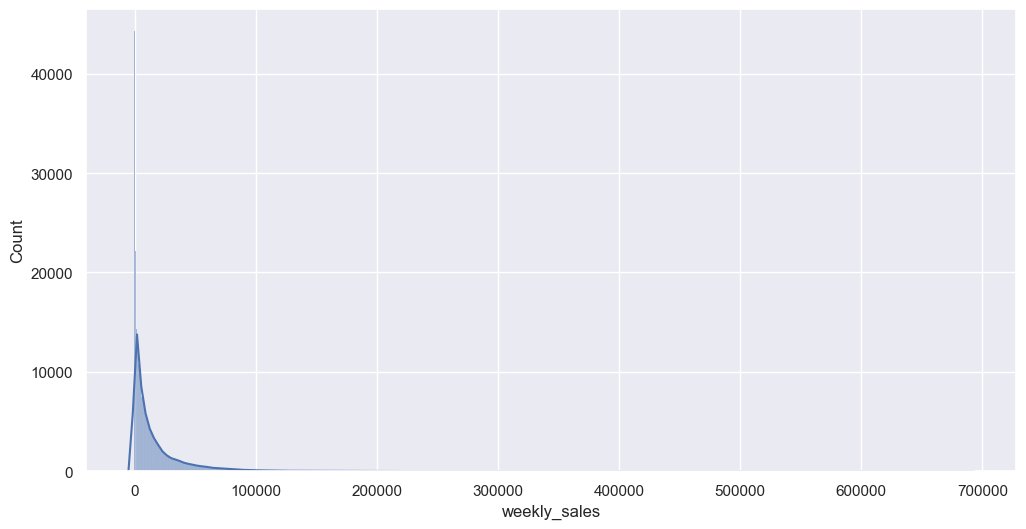

In [58]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(df1['weekly_sales'], kde = True, ax = ax)

plt.show()

### Numerical Variable 


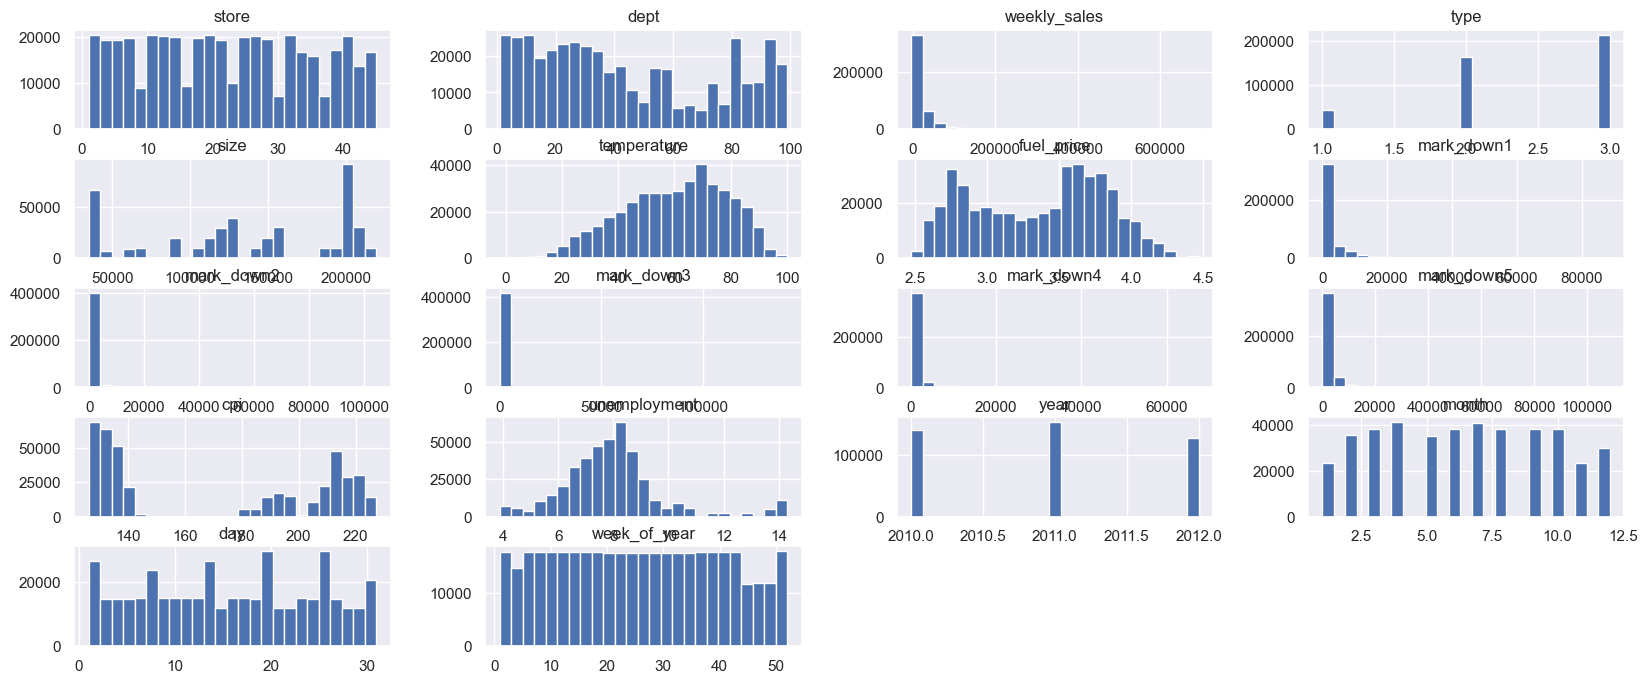

In [97]:
# entendendo um pouco a distruição dos dados de cada atributo
num_attributes.hist(bins=25);

## Existe algum setor que desempenhe melhor?




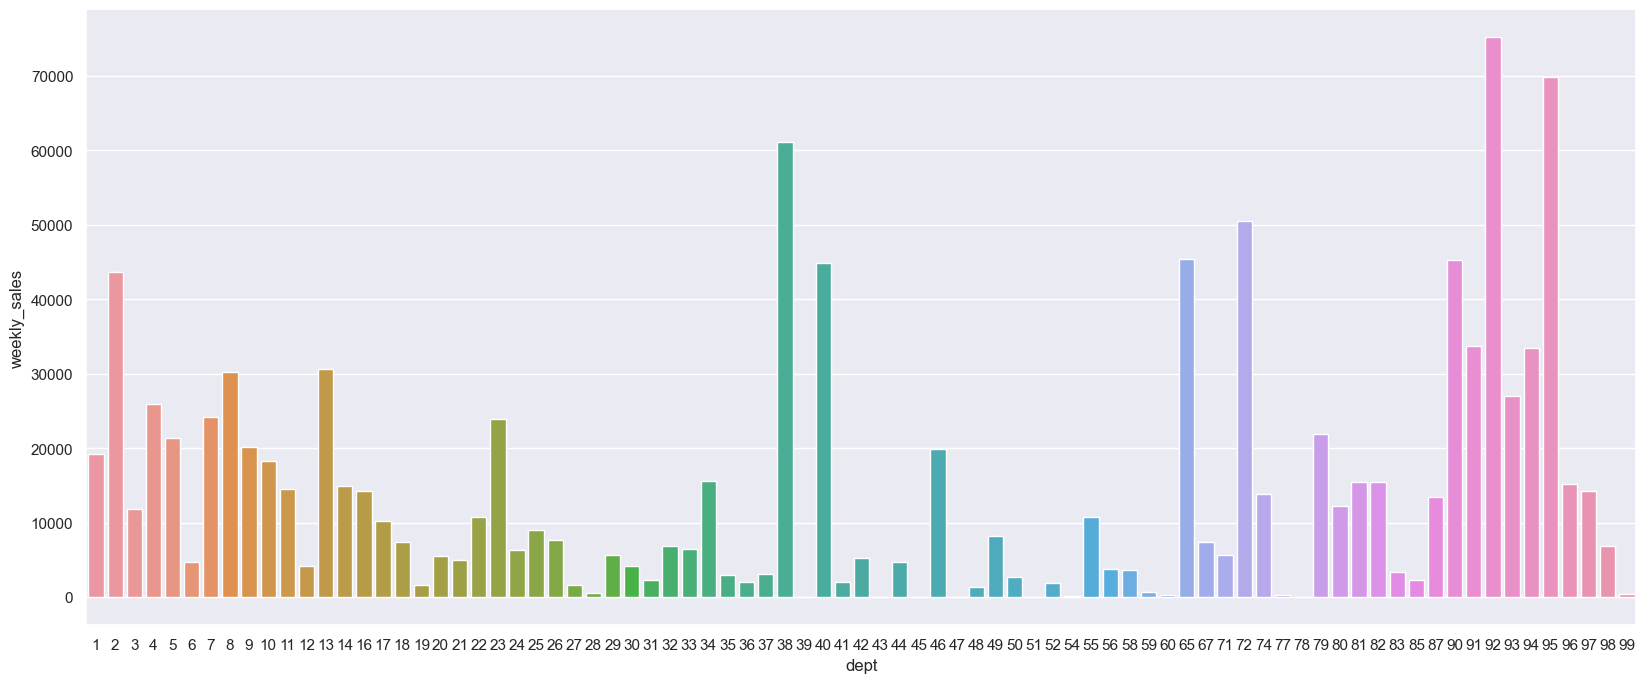

In [79]:
aux = df1[['dept', 'weekly_sales']].groupby('dept').mean().reset_index()
aux

sns.barplot(data=aux, x='dept', y='weekly_sales');

Nota-se em média os setores que mais vendem: 2,8,13,38,40,65,72,90,91,92,94,95. Com destaque para o departamento 92.





In [8]:
aux = df1.query("dept == 92")[['dept', 'weekly_sales']].groupby('dept').mean().reset_index()
aux

,dept,weekly_sales
0,92,75204.87


In [29]:
dept92 = 75204.87

In [30]:
print(f'O setor 92 possui faturamento semanal em média de ${dept92} dólares')

O setor 92 possui faturamento semanal em média de $75204.87 dólares


## Qual é o impacto dos feriados (promoções também) nas vendas das lojas?




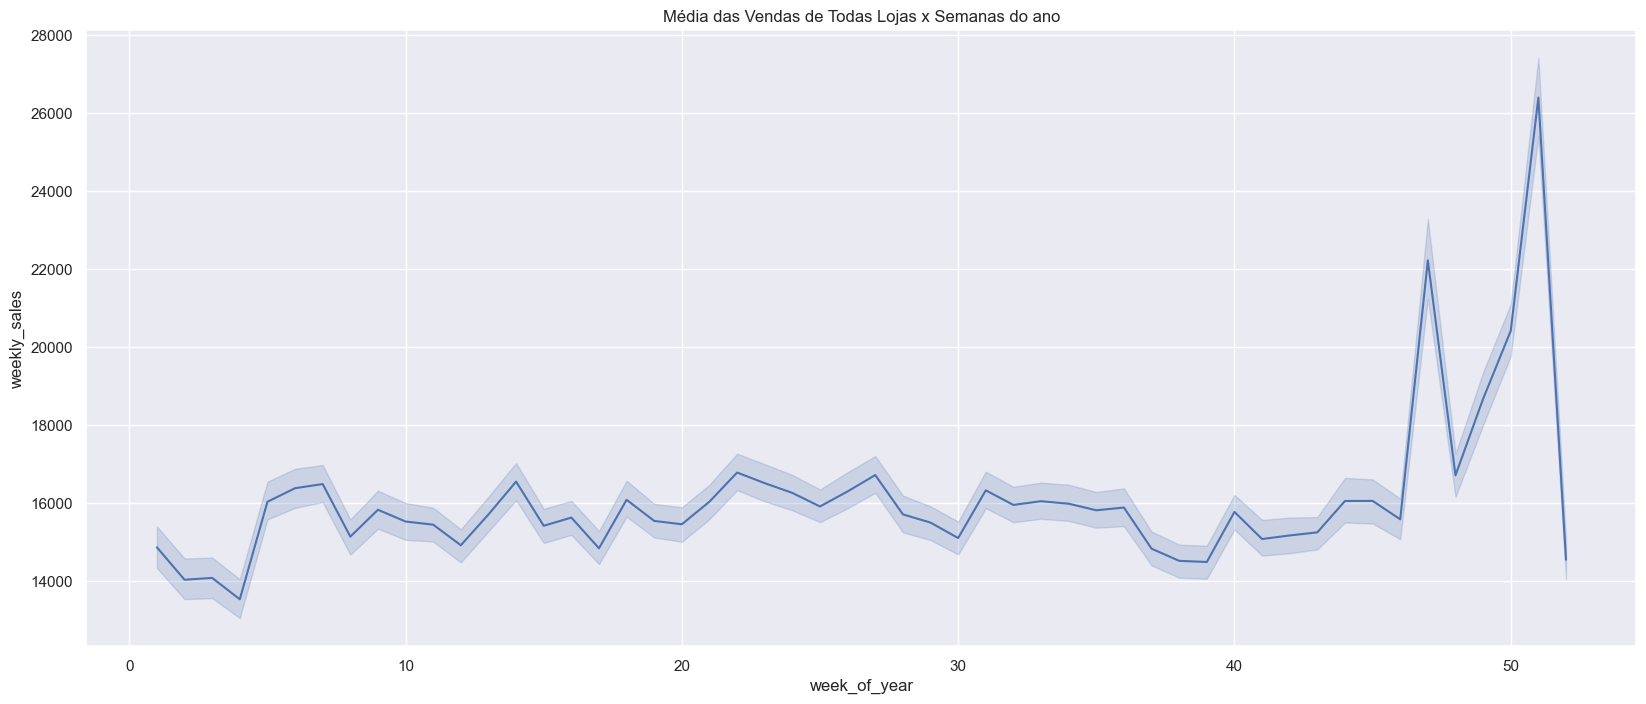

In [48]:
aux = df1[['week_of_year', 'weekly_sales']].groupby('week_of_year').mean().reset_index()
aux

sns.lineplot(data=df1, x='week_of_year', y='weekly_sales').set(title='Média das Vendas de Todas Lojas x Semanas do ano');

Nota-se um pico de vendas elevado próximo aos feriados de ação de graças, seguido da Black Friday e posteriormente uma forte tendência no aumento das vendas na semana do feriado natalino.

Em seguida, vamos calcular o aumento médio das vendas semanais nestes períodos de feriados.



In [40]:
revenues_until_october = round(df1.loc[df1['week_of_year'] <= 44]['weekly_sales'].mean(), 2)

In [41]:
revenues_nov_dec = round(df1.loc[df1['week_of_year'] > 44]['weekly_sales'].mean(), 2)

In [42]:
percentile_revenues = (revenues_nov_dec - revenues_until_october) / revenues_until_october
round(percentile_revenues * 100, 2)

20.62

Portanto, podemos concluir que houve um impacto em média de 21% sobre as vendas neste período.



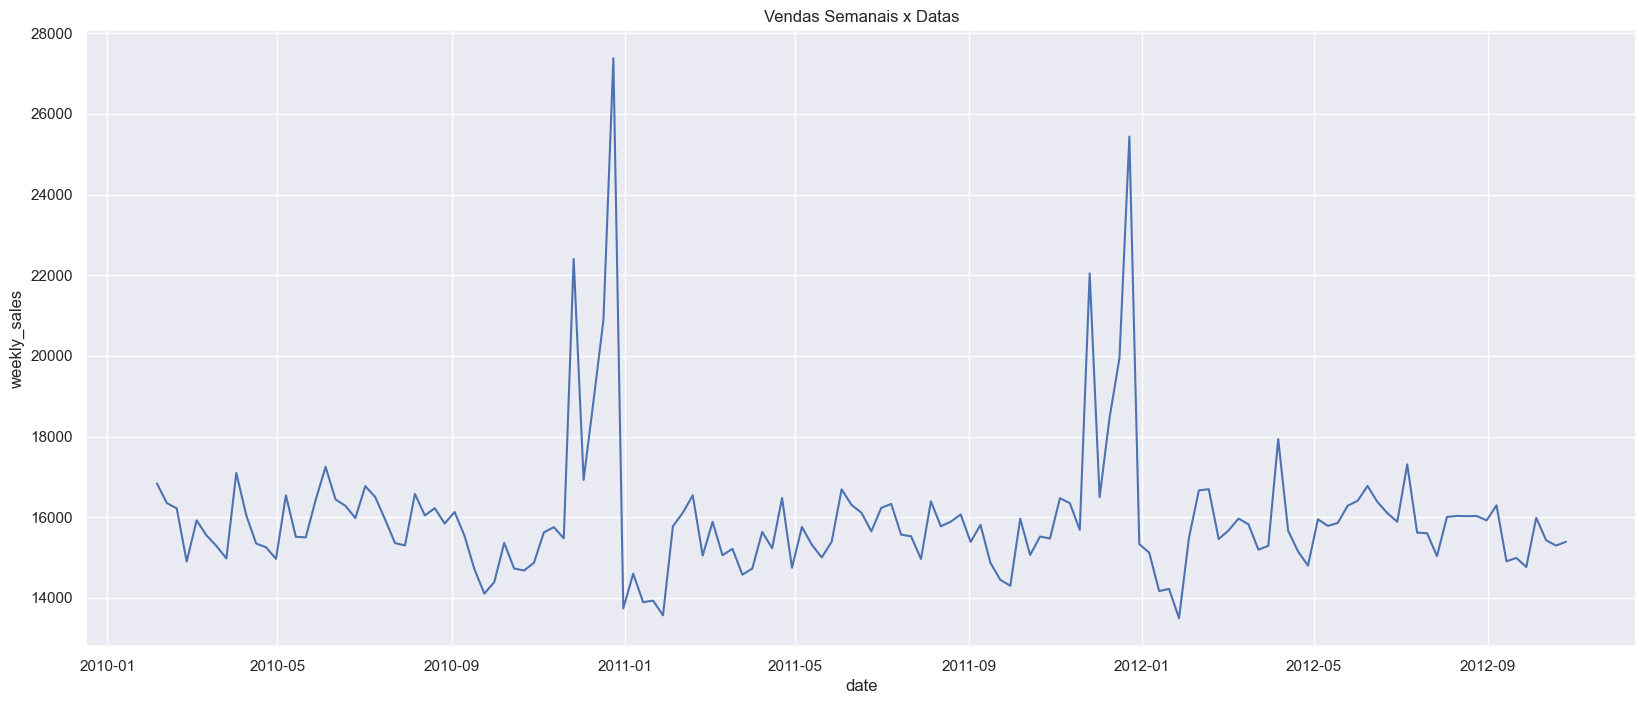

In [43]:
impact_sales = df1[['date', 'weekly_sales']].groupby('date').mean().reset_index()

sns.lineplot(data=impact_sales, x='date', y='weekly_sales').set(title='Vendas Semanais x Datas');

Nota-se que nos anos de 2010 e 2011 dois picos de maiores vendas ocorreram devido ao feriado de ação de graças, e Natal, fazendo gerar altos impactos sobre as vendas. Conforme calculado na análise acima, é possível identificar o aumento de 21% sobre as vendas nestes períodos de pico.




Por outro lado, o feriado do Dia do Trabalho e Superbowl impactaram levemente sobre os feriados de maior pico como Ação de Graças e Natal.


Há uma leve queda nas vendas em dezembro de 2011 comparado ao mesmo mês em 2012.

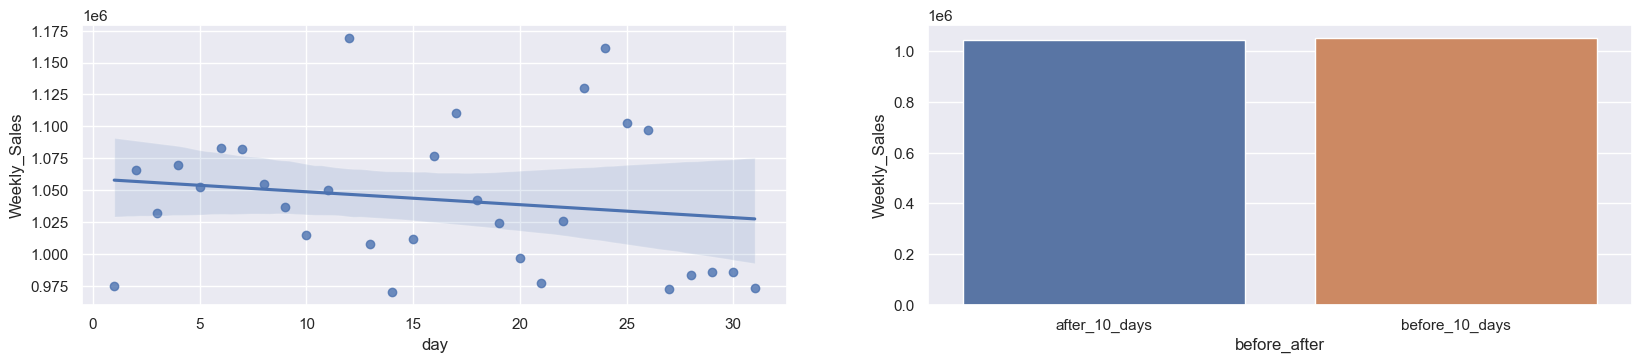

In [188]:
aux = df1[['day','weekly_sales']].groupby('day').mean().reset_index()

plt.subplot(2,2,1)
sns.regplot(x='day', y='weekly_sales', data=aux);

# creating a new feature
df1['before_after'] = df1['day'].apply(lambda x : 'before_10_days' if x <= 10 else 'after_10_days')
df2= df1[['before_after', 'seekly_sales']].groupby('before_after').mean().reset_index()

plt.subplot(2,2,2)
sns.barplot(x='before_after', y='seekly_sales', data=df2);

Nota-se há uma leve queda no número de vendas, depois do dia 15 em diante.

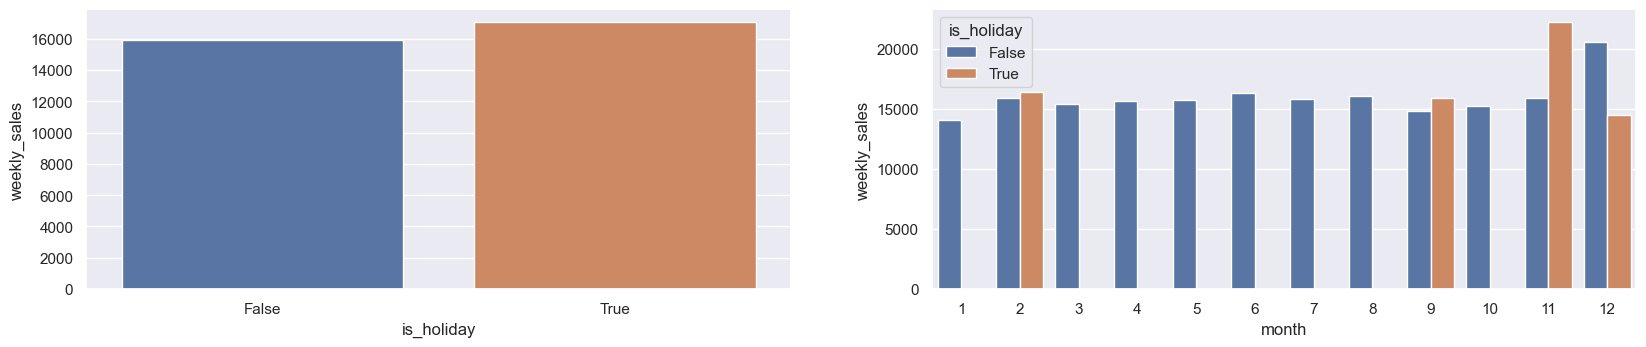

In [14]:
aux = df1[['weekly_sales', 'is_holiday']].groupby('is_holiday').mean().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(data=aux, x='is_holiday', y='weekly_sales');

aux2 = df1[['month', 'is_holiday', 'weekly_sales']].groupby(['month','is_holiday']).mean().reset_index()
plt.subplot(2, 2, 2)
sns.barplot(x='month', y='weekly_sales', hue='is_holiday', data=aux2);

Nota-se que dias de feriado, as lojas vendem em média mais do que dias normais.


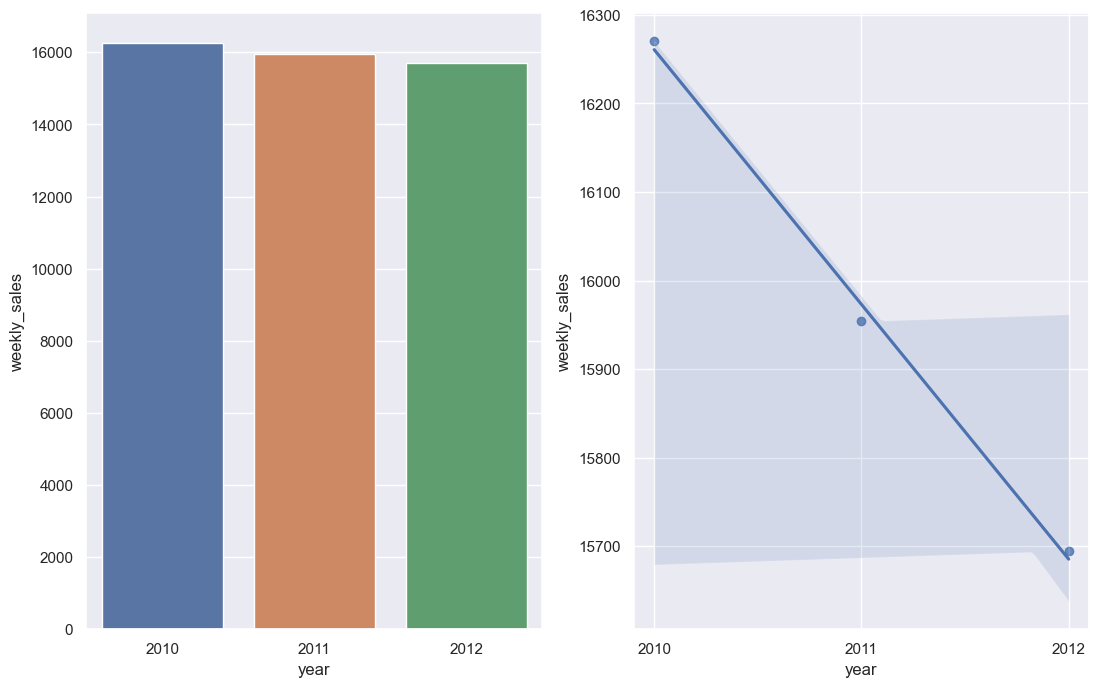

In [66]:
aux = df1[['year', 'weekly_sales']].groupby('year').mean().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='weekly_sales', data=aux);

plt.subplot(1, 3, 2)
ax = sns.regplot(x='year', y='weekly_sales', data=aux);
ax.xaxis.set_major_locator(ticker.MultipleLocator(1));

Podemos dizer que as vendas no ano de 2010 foram levemente mais expressivas do que no ano de 2011 e 2012, além de ter ocorrido uma queda no volume das vendas no último ano (2012).



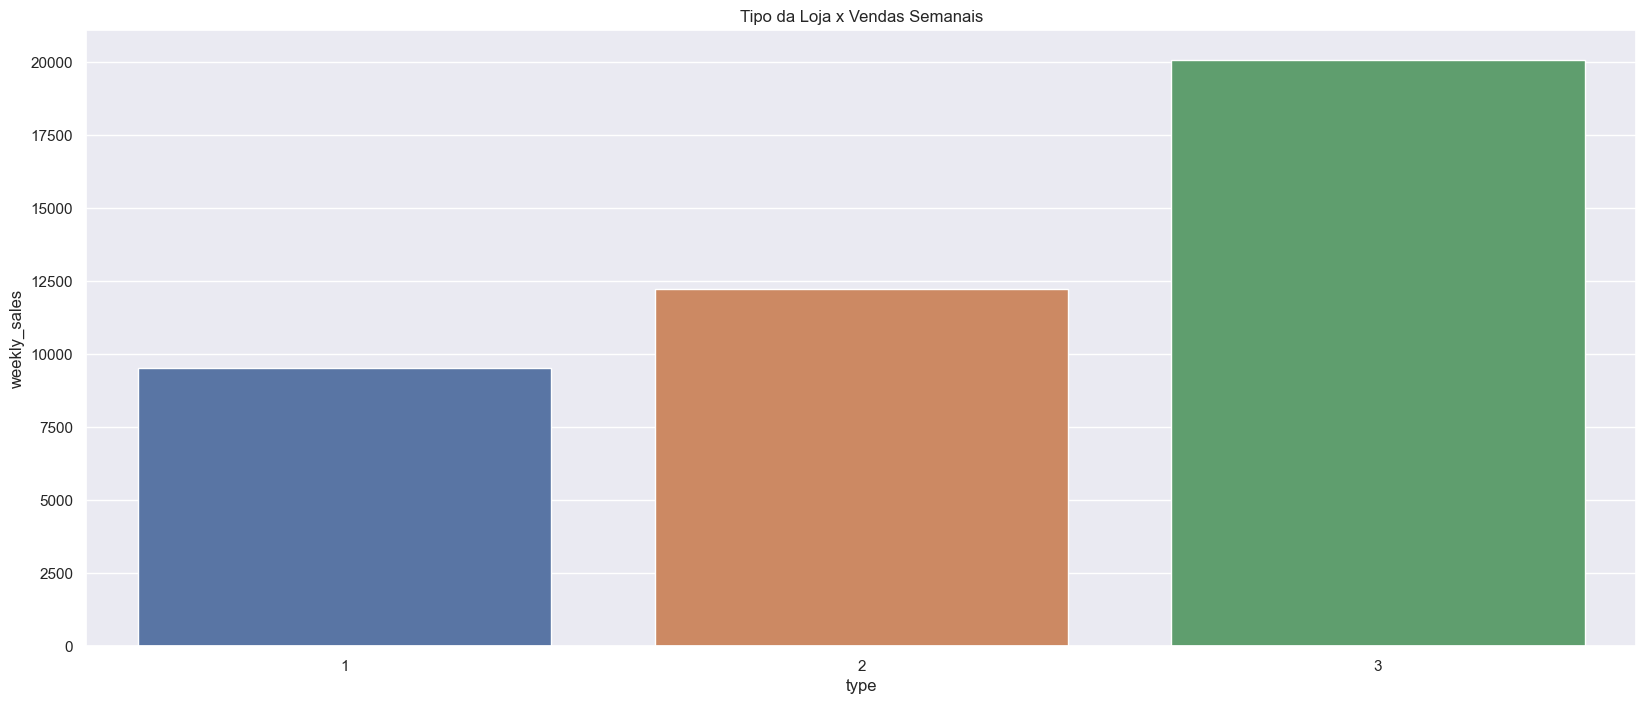

In [37]:
aux=df1[['type', 'weekly_sales']].groupby('type').mean().reset_index()

sns.barplot(data=aux, x='type', y='weekly_sales').set(title='Tipo da Loja x Vendas Semanais');

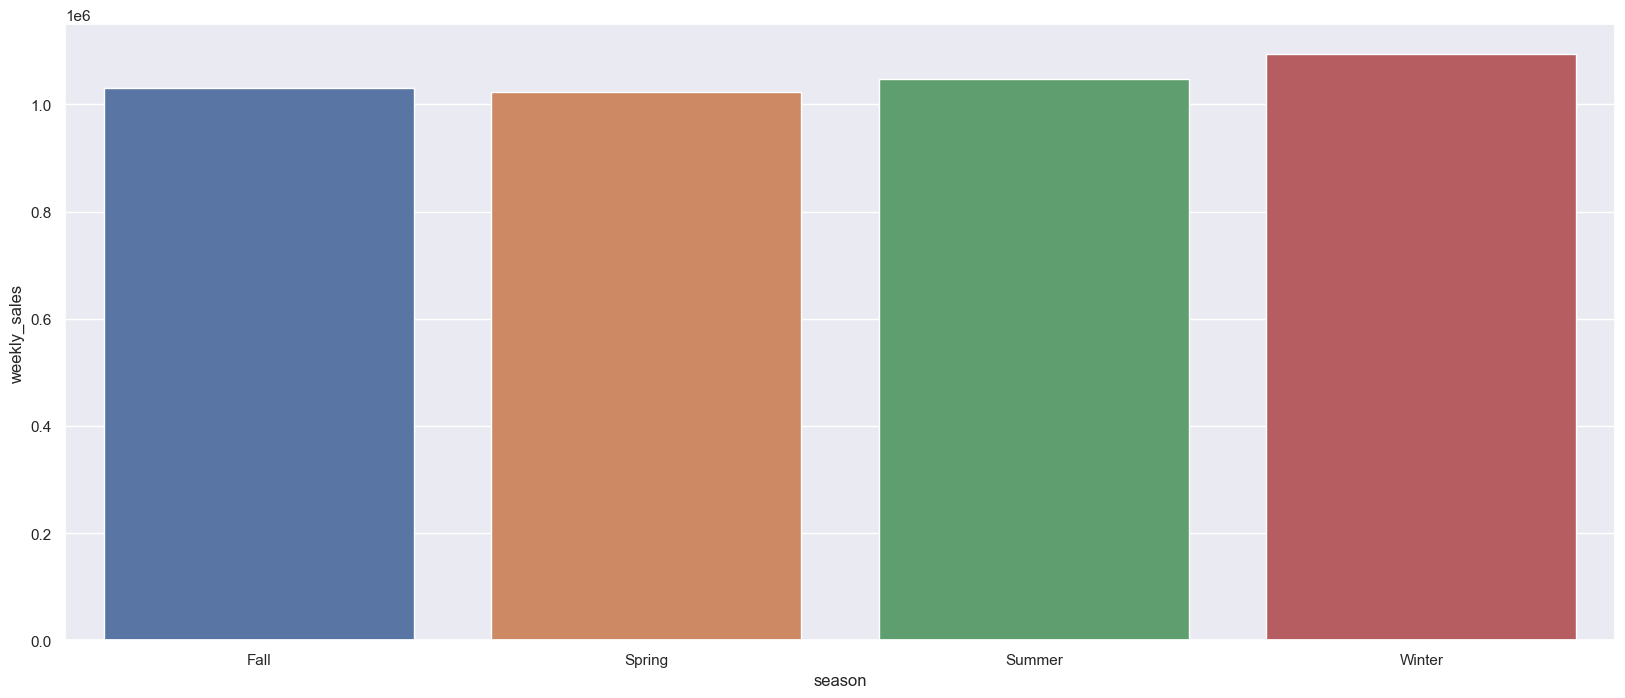

In [320]:
aux = df1[['season', 'weekly_sales']].groupby('season').mean().reset_index()
aux.head()

sns.barplot(data=aux, x='season', y='weekly_sales');

Nota-se que na estação de Inverno, em média, as vendas tendem a ser maior em relação as demais estações.


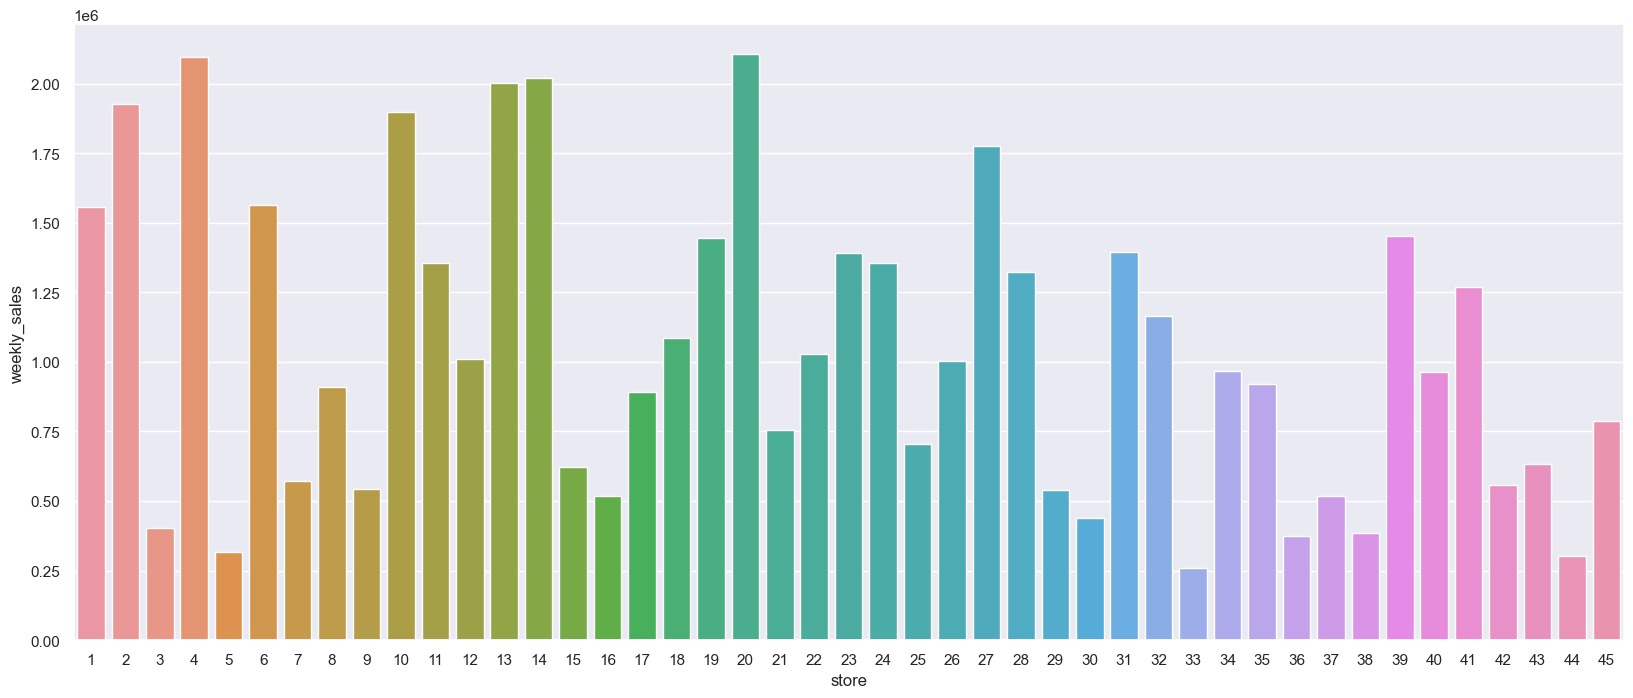

In [97]:
aux = df1[['store', 'weekly_sales']].groupby('store').mean().reset_index()
aux.head()

sns.barplot(data=aux, x='store', y='weekly_sales');

As lojas de maior destaque são as de nº 4, 10, 13, 14 ,20.


Nota-se a distribuição média das vendas semanais de cada uma das lojas.

Lojas do tipo 3 possuem maior volume de vendas.


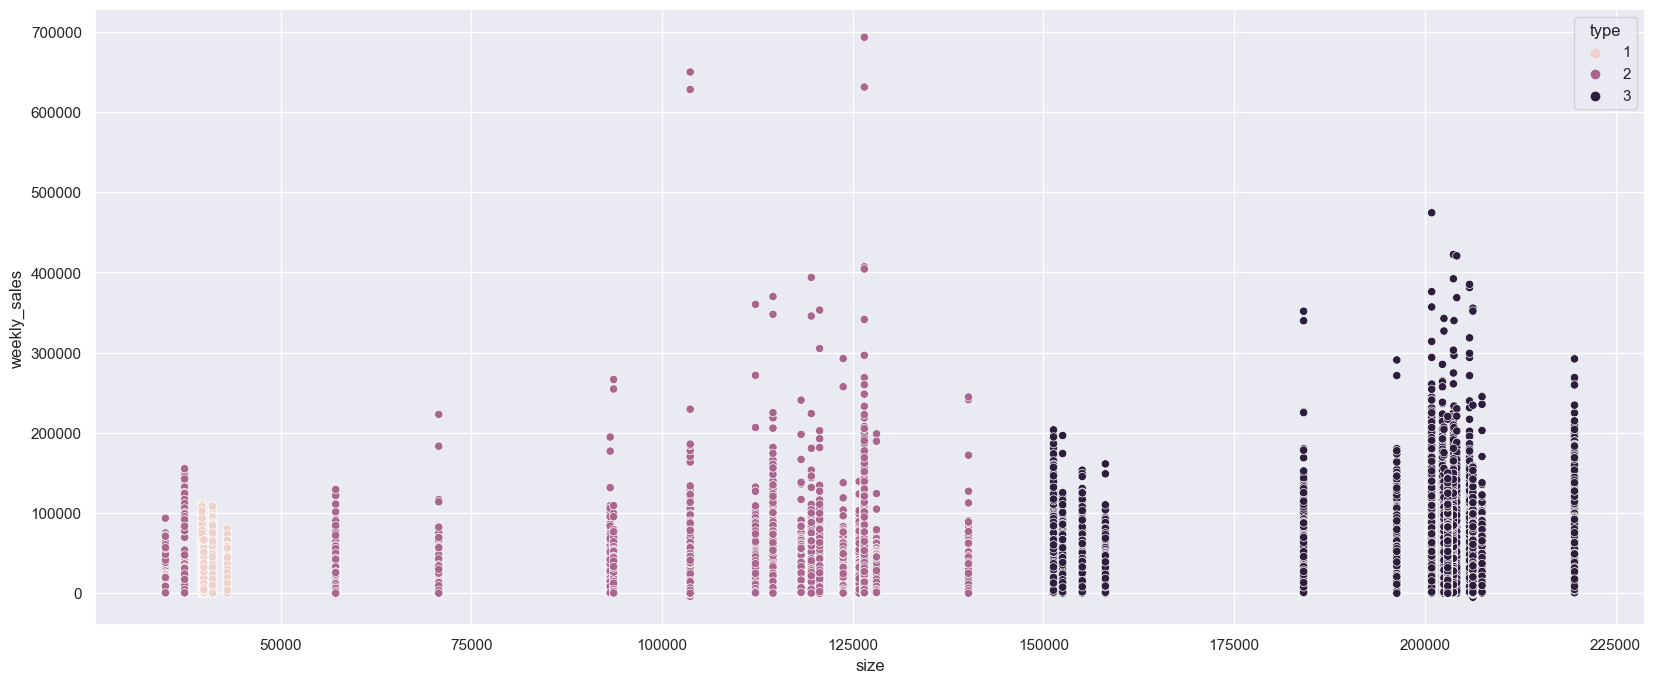

In [232]:
sns.scatterplot(data=df1,x='size',y='weekly_sales',hue='type');

Nota-se que o tamanho da loja e o tipo de loja impacta diretamente a quantidade de vendas. Lojas de médio e grande porte vendem mais.



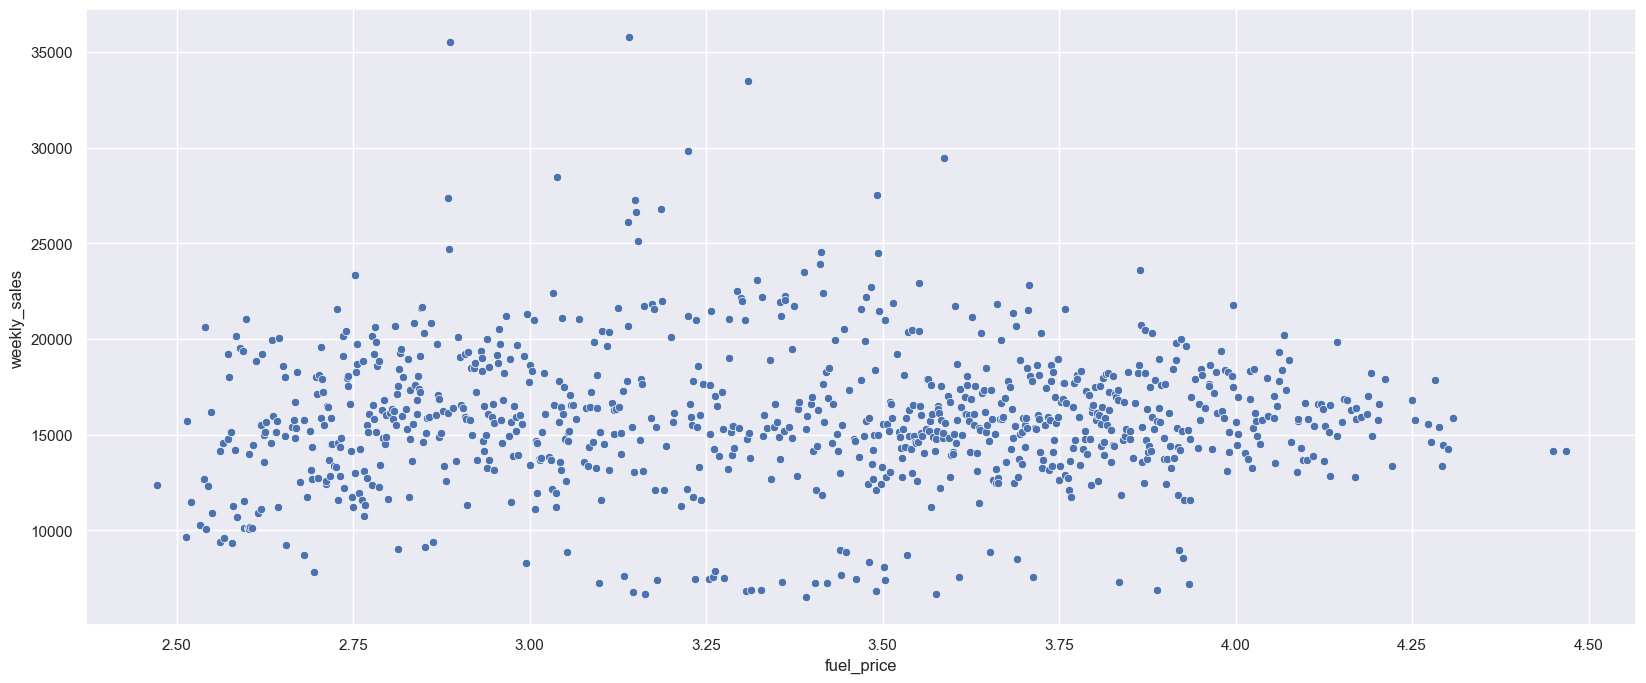

In [84]:
aux = df1[['fuel_price', 'weekly_sales']].groupby('fuel_price').mean()
sns.scatterplot(data=aux, x='fuel_price', y='weekly_sales');

Nota-se que o preço do combustível não influencia diretamente nas vendas




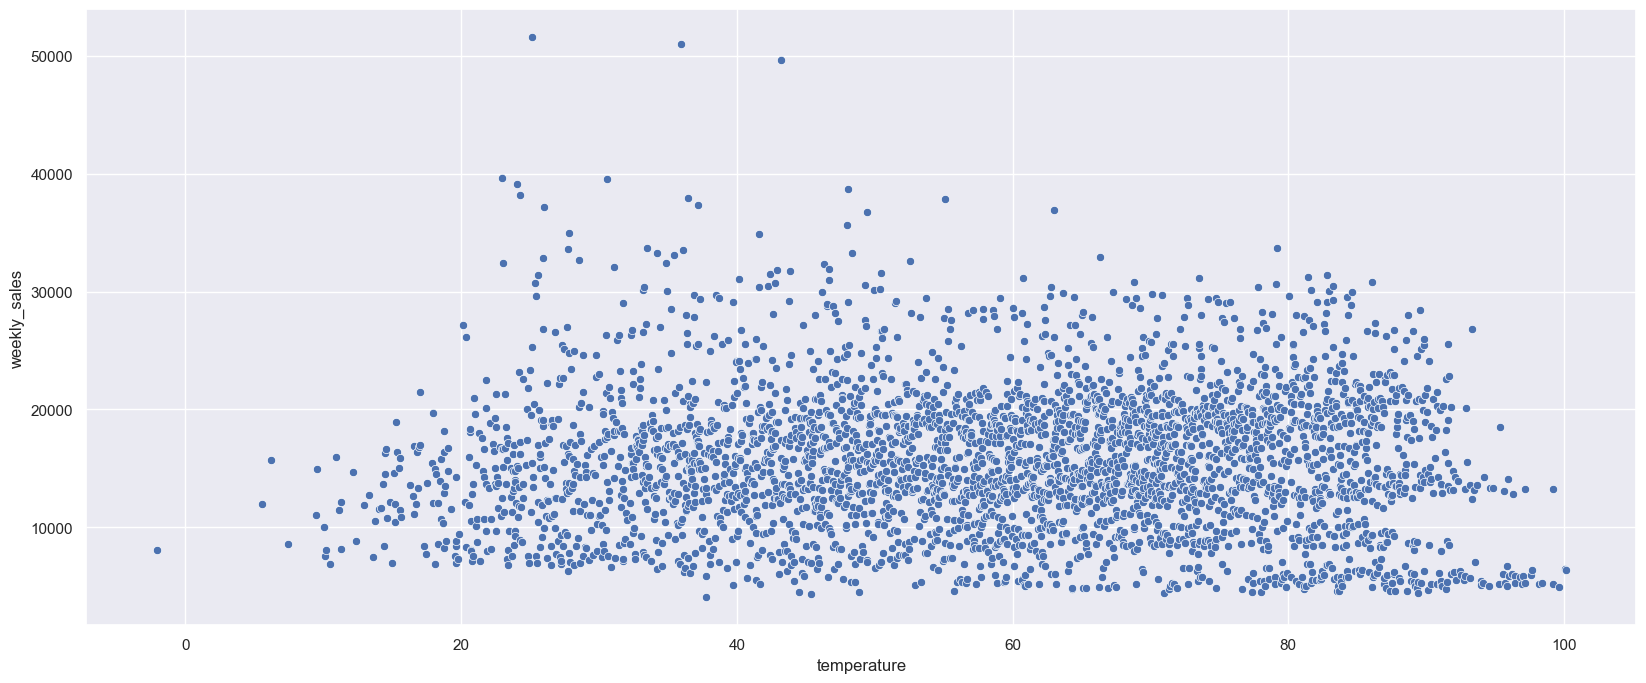

In [91]:
aux = df1[['temperature', 'weekly_sales']].groupby('temperature').mean()
sns.scatterplot(data=aux, x='temperature', y='weekly_sales');

Nota-se que as vendas não dependem da temperatura, somente em condições muito elevadas ou muito baixas as vendas são menores.


In [52]:
aux = df1[['mark_down1', 'year']].groupby('year').sum().reset_index()
aux

,year,mark_down1
0,2010,0.00
1,2011,107456230.27
2,2012,984441611.27


Não há valores de 'markdowns' disponíveis nas datas anteriores à Outubro de 2011.


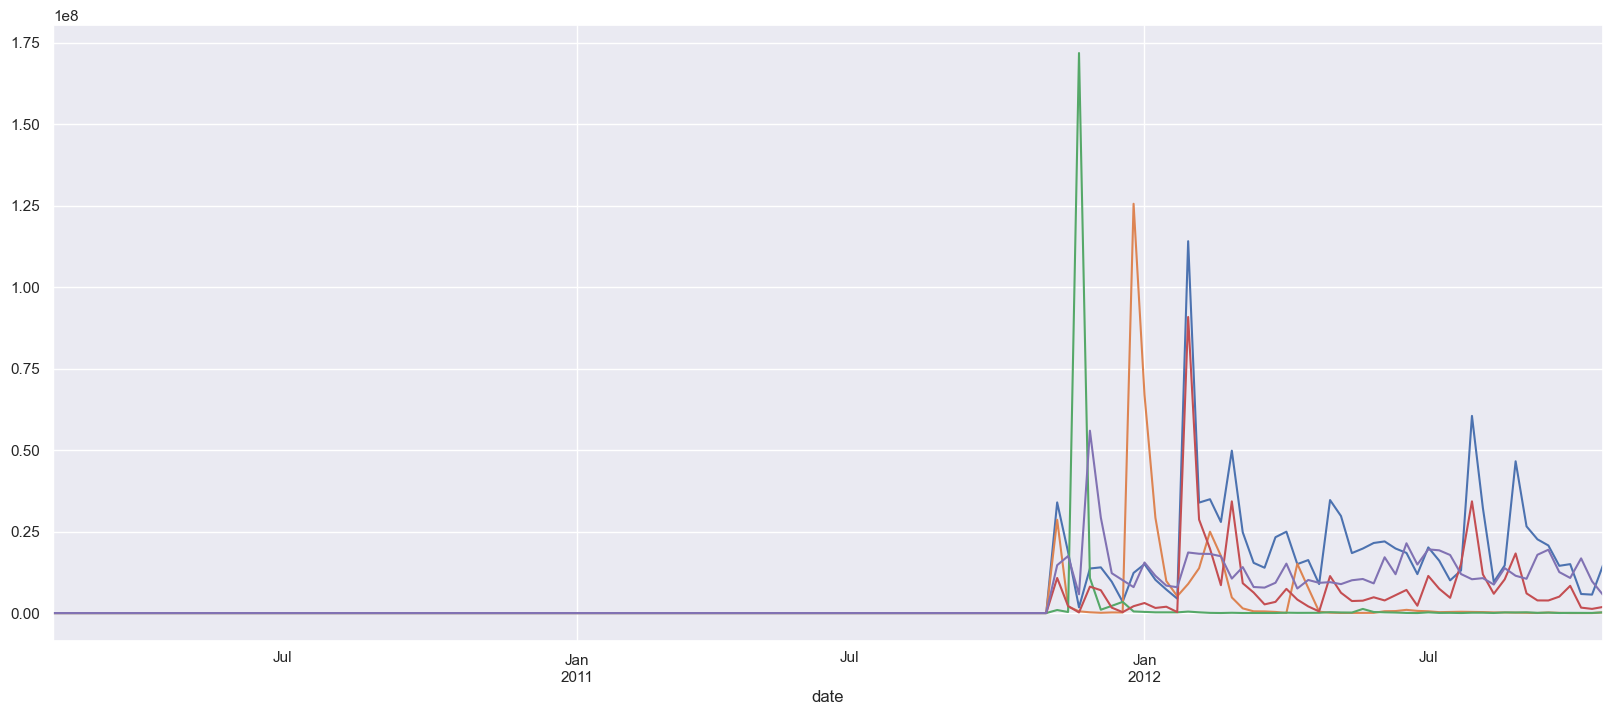

In [50]:
df1.groupby(['date'])['mark_down1'].sum().plot(label='mark_down1')
df1.groupby(['date'])['mark_down2'].sum().plot(label='mark_down2')
df1.groupby(['date'])['mark_down3'].sum().plot(label='mark_down3')
df1.groupby(['date'])['mark_down4'].sum().plot(label='mark_down4')
df1.groupby(['date'])['mark_down5'].sum().plot(label='mark_down5');

Nota-se picos de 'markdowns' no intervalo de novembro de 2011 a setembro de 2012 devido aos feriados de  Ação de Graças, Natal, SuperBowl e LaborDay

Observa-se que as promoções começam impactar sobre alguns dias antes de ocorrerem os feriados e durante eles.


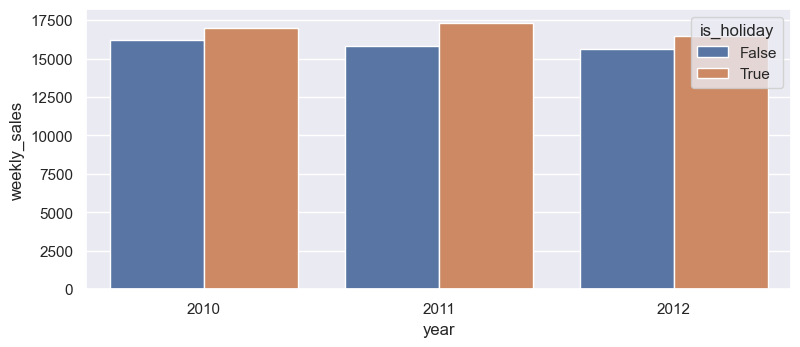

In [18]:
aux2 = df1[['year', 'is_holiday', 'weekly_sales']].groupby(['year','is_holiday']).mean().reset_index()
plt.subplot(2, 2, 2)
sns.barplot(x='year', y='weekly_sales', hue='is_holiday', data=aux2);

Nota-se que ano à ano os feriados em média venderam mais.


# É possível estimar as vendas das lojas por semana em datas futuras de 2012–11–02 a 2013–07-26? Se sim, quais seriam esses valores?


In [8]:
df2 = df1.copy()

In [9]:
# função criada para o calculo da métrica MAE
# Entradas da função: dataset, vendas atuais, previsão de vendas
def MAE(dataset, real, predicted):
  
    weights = dataset.is_holiday.apply(lambda x: 5 if x else 1) # Valor do peso. Se w = 5 tem feriado durante a semana e w = 1 caso contrário.
    print(weights)
    # formula do MAE
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [10]:
# função para predição das vendas
def random_forest(n_estimators, max_depth): # parâmetros de entrada: nº de arvores e profundidades
    result = [] 
    for estimator in n_estimators:
        for depth in max_depth:
            maes_cv = [] # armazenando o valor de MAE encontrado
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3) # dividi-se os dados em dois conjuntos. 70% para treino e 30% para teste.
                rf = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                rf.fit(x_train, y_train) 
                predicted = rf.predict(x_test) # previsões encontradas com foco em 30% de dados de teste
                maes_cv.append(MAE(x_test, y_test, predicted)) # add o valor do MAE a variavel 'maes_cv'
            print('MAE:', np.mean(maes_cv)) # print do valor de mae encontrado
            result.append({'max_depth': depth, 'estimators': estimator, 'MAE': np.mean(maes_cv)}) # cria uma lista com a profundidade e numero de arvores e o valor mae associado.
    return pd.DataFrame(result) # retorna um novo dataframe com valores comentados na linha anterior

In [11]:
X_train = df2[['store','is_holiday', 'dept', 'week_of_year', 'year', 'size','type']] # features utilizadas
Y_train = df2['weekly_sales'] # o valor predito: vendas semanais

In [210]:
n_estimators = [4, 17, 81 ] # numero de estimadores para as arvores 
max_depth = [8, 22, 99] # valores para profundidade da arvore
# chamando a função random_forest 
random_forest(n_estimators, max_depth)

k: 1 , n_estimators: 4 , max_depth: 8
417217    1
368256    1
306879    5
71271     1
357566    1
         ..
394020    1
253284    1
66155     1
26500     1
168560    1
Name: is_holiday, Length: 126471, dtype: int64
k: 2 , n_estimators: 4 , max_depth: 8
373717    1
110045    5
176450    1
305968    1
412425    1
         ..
386912    1
82104     1
207574    1
188831    1
147209    1
Name: is_holiday, Length: 126471, dtype: int64
k: 3 , n_estimators: 4 , max_depth: 8
173018    5
188011    1
235622    1
345269    1
293552    1
         ..
296725    5
342283    1
21904     1
320470    1
57267     1
Name: is_holiday, Length: 126471, dtype: int64
k: 4 , n_estimators: 4 , max_depth: 8
32227     1
136357    1
398965    1
212936    1
155784    1
         ..
230036    1
177708    1
346047    1
112360    1
292469    1
Name: is_holiday, Length: 126471, dtype: int64
MAE: 5956.235000000001
k: 1 , n_estimators: 4 , max_depth: 22
220868    1
320758    1
152646    1
198336    1
168092    1
         .

,max_depth,estimators,MAE
0,8,4,5956.24
1,22,4,1722.04
2,99,4,1727.18
3,8,17,5947.20
4,22,17,1580.62
5,99,17,1577.19
6,8,81,5842.18
7,22,81,1563.88
8,99,81,1545.95


In [12]:
#treinando o modelo
rf = RandomForestRegressor(n_estimators=81, max_depth=99)
rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=99, n_estimators=81)

In [13]:
# features que serão utilizados no modelo
X_test = df_final_test[['Store','IsHoliday', 'Dept', 'Week_Of_Year', 'Year', 'Size','Type']]
# predição dos valores a partir do dataframe de test
predict = rf.predict(X_test)

In [14]:
df_sample_predictions['Weekly_Sales'] = predict

In [15]:
df_sample_predictions

,Id,Weekly_Sales
0,1_1_2012-11-02,31267.43
1,1_1_2012-11-09,46234.00
2,1_1_2012-11-16,9292.11
3,1_1_2012-11-23,36341.90
4,1_1_2012-11-30,26407.08
...,...,...
115059,45_98_2013-06-28,3443.57
115060,45_98_2013-07-05,3866.89
115061,45_98_2013-07-12,52740.34
115062,45_98_2013-07-19,6318.75


In [222]:
# testando um dataframe com as lojas e as datas desse perido

# future_sales = pd.DataFrame([[45, 5, 28, 2013]])

# fs = rf.predict(future_sales)
# x = round(fs[0],2)

ValueError: X has 4 features, but RandomForestRegressor is expecting 7 features as input.

In [130]:
total_sales = round(df_sample_predictions['Weekly_Sales'].sum(), 2)

In [135]:
print(f'O faturamento total previsto das vendas nestas datas futuras será de ${total_sales} dólares')

O faturamento total previsto das vendas nestas datas futuras será de $1895774952.14 dólares


In [ ]:
# exportando arquivo com as prediçoes das vendas semanais futuras
df_sample_predictions.to_csv('predictions_sales.csv', index=False)

In [ ]:
Entregar valor, melhorar a experiência do cliente e aumentar o faturamento